## Fresh notebook for using `halotools` on PDR catalog 

In [25]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()
#import linetools.utils as ltu
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
from colossus.halo import profile_nfw
%config InlineBackend.figure_format = 'retina'

In [26]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo.fits'

hdu1 = fits.open(data_file)
data_table = Table(hdu1[1].data)

# set cosmology params
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

# cut the table
pdr_use = Table(names = data_table.colnames)

for i in range(len(np.array(data_table['logm_max']))):
    if data_table['logm_max'][i] > 11.5 and data_table['z_best'][i] > .25 and data_table['z_best'][i] < .45:
        pdr_use.add_row(data_table[i])
        
# get rid of two bad galaxies
pdr_use.remove_row(np.where(pdr_use['ra'] == 33.121181211450285)[0][0])
pdr_use.remove_row(np.where(pdr_use['ra'] == 333.7062012551158)[0][0])

When using halotools, the assumption in the function is that positions are in comoving with units Mpc/h. So when I find the halo radius for the function, it needs to be in a form the function likes. Unfortunately, the observational data does not have inputs like that. I should look deeper into the function.

## Test halotools function on mock data

In [27]:
model = data_pth + 'um_ins_exs_logms_10.8_asap_180813_vel.fits'

hdu1 = fits.open(model)
um_table = Table(hdu1[1].data)

# sort table
um_table.sort('logms_max')
um_table.reverse() # rank order by mass
model_z = 0.37

from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo # um uses planck cosmology
# find the z-space distortions
z_dis = apply_zspace_distortion(um_table['z'], um_table['vz'], model_z, cosmo, 400.0)
um_table['z_dist'] = z_dis

In [28]:
# define um cosmology
params = {'flat': True , 'H0': 67.77 , 'Om0': 0.307115 , 'Ob0': 0.048206, 'sigma8': 0.8228, 'ns': 0.96}
h = 0.6777
cosmology.addCosmology('SMDPL',params) # this is what Song had me use when doing the sat frac
cosmo = cosmology.setCosmology('SMDPL')

All units are currently in comoving Mpc/h

#### True satellite fractions for number reference

In [29]:
centrals_true = um_table[um_table['upid'] == -1]
sats_true = um_table[um_table['upid'] != -1]


# from Song's satellite finding code
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(um_table['logms_max'], bins=mass_bins)
hist_cen, edges_cen = np.histogram(centrals_true['logms_max'], bins=mass_bins)
hist_sat, edges_sat = np.histogram(sats_true['logms_max'], bins=mass_bins)

mass_center_true = np.log10((10**edges_all[1:] + 10**edges_all[:-1]) / 2)

f_sat_true = (hist_sat / hist_all) * 100

In [30]:
# cut model table like marie mentioned

# Cut in Mh_vir to speed things up
stellarcut_indices = np.where(um_table['logms_max'] > 11.5)[0]

# row index where 95% of galaxies with M_* > 11.5 are above it
last_idx = stellarcut_indices[int(len(stellarcut_indices)*0.99)]
UM_cut = um_table[0:last_idx]

# get virial radii
mvir = UM_cut['logmh_vir']

# m_to_r use 'vir' definition
r_h = mass_so.M_to_R((10**mvir)*h , model_z, 'vir') * 1e-3 * 1.37 #comoving Mpc/h
UM_cut['r_vir'] = r_h

# Make an index column
UM_cut['index'] = np.zeros(len(UM_cut['logms_max']))
UM_cut['flag'] = np.zeros(len(UM_cut['logms_max']))

for i in range(len(UM_cut['index'])):
     UM_cut['index'][i] = i

* Now I want to develop a new satellite finding function using `halotools`

In [31]:
from halotools.mock_observables import counts_in_cylinders

In [32]:
# first, see if I can identify satellites of a single central

def CiC_satellite(i, in_table , full_cat, half_length):
    
    # define "central" galaxy of interest
    central_galaxy = in_table[i]
    
    # make a copy of the table where m < m_central
    cat_use = copy.deepcopy(full_cat[(full_cat['logms_max'] > central_galaxy['logms_max'])])
    # cat_use = copy.deepcopy(in_table)
    
    # now I need arrays to input into halotools x1,y1,z1 = cent, x2,y2,z2 = the rest
    
    # positional args
    x1, y1, z1 = central_galaxy['x'], central_galaxy['y'], central_galaxy['z_dist']
    sample1 = np.vstack([x1, y1, z1]).T
    x2, y2, z2 = cat_use['x'], cat_use['y'], cat_use['z_dist']
    sample2 = np.vstack([x2, y2, z2]).T
    
    # virial radius of central
    rvir_cent = central_galaxy['r_vir']
    
    box = 400 # um box size
    
    pairs, indices = counts_in_cylinders( sample1, sample2, proj_search_radius = rvir_cent,
                                        cylinder_half_length = half_length, period = box, return_indexes = True)
    return(pairs, indices)

In [33]:
# test that the function will find satellites
pair, index = CiC_satellite(1, UM_cut, UM_cut, 15)
print(pair, index)

[0] []


Awesome! That also works super fast. Now, like I did in the previous analysis, I will write a partner function to iterate over this one and flag the satellites.

Try with a smaller sample:

In [34]:
bin_11_5 = Table(names = UM_cut.colnames)
bin_11_6 = Table(names = UM_cut.colnames)
bin_11_7 = Table(names = UM_cut.colnames)
bin_11_8 = Table(names = UM_cut.colnames)
bin_11_9 = Table(names = UM_cut.colnames)
bin_12_0 = Table(names = UM_cut.colnames)
bin_12_1 = Table(names = UM_cut.colnames)
bin_12_2 = Table(names = UM_cut.colnames)

for i in range(len(UM_cut)):
    if UM_cut['logms_max'][i] > 11.5 and UM_cut['logms_max'][i] < 11.6:
        bin_11_5.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 11.6 and UM_cut['logms_max'][i] < 11.7:
        bin_11_6.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 11.7 and UM_cut['logms_max'][i] < 11.8:
        bin_11_7.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 11.8 and UM_cut['logms_max'][i] < 11.9:
        bin_11_8.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 11.9 and UM_cut['logms_max'][i] < 12.0:
        bin_11_9.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 12.0 and UM_cut['logms_max'][i] < 12.1:
        bin_12_0.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 12.1 and UM_cut['logms_max'][i] < 12.2:
        bin_12_1.add_row(UM_cut[i])
    if UM_cut['logms_max'][i] > 12.2:
        bin_12_2.add_row(UM_cut[i])

In [35]:
bin_11_5_counts = []
bin_11_6_counts = []
bin_11_7_counts = []
bin_11_8_counts = []
bin_11_9_counts = []
bin_12_0_counts = []
bin_12_1_counts = []
bin_12_2_counts = []

for i in range(len(bin_11_5)):
    bin_11_5_counts.append(CiC_satellite(i, bin_11_5, UM_cut, 20)[0][0])
for i in range(len(bin_11_6)):
    bin_11_6_counts.append(CiC_satellite(i, bin_11_6, UM_cut, 20)[0][0])
for i in range(len(bin_11_7)):
    bin_11_7_counts.append(CiC_satellite(i, bin_11_7, UM_cut, 20)[0][0])
for i in range(len(bin_11_8)):
    bin_11_8_counts.append(CiC_satellite(i, bin_11_8, UM_cut, 20)[0][0])
for i in range(len(bin_11_9)):
    bin_11_9_counts.append(CiC_satellite(i, bin_11_9, UM_cut, 20)[0][0])
for i in range(len(bin_12_0)):
    bin_12_0_counts.append(CiC_satellite(i, bin_12_0, UM_cut, 20)[0][0])
for i in range(len(bin_12_1)):
    bin_12_1_counts.append(CiC_satellite(i, bin_12_1, UM_cut, 20)[0][0])
for i in range(len(bin_12_2)):
    bin_12_2_counts.append(CiC_satellite(i, bin_12_2, UM_cut, 20)[0][0])

In [36]:
bins = [0,1,2,3,4,5,6,7]
hist_11_5, edges_11_5 = np.histogram(bin_11_5_counts,bins)
hist_11_6, edges_11_6 = np.histogram(bin_11_6_counts,bins)
hist_11_7, edges_11_7 = np.histogram(bin_11_7_counts,bins)
hist_11_8, edges_11_8 = np.histogram(bin_11_8_counts,bins)
hist_11_9, edges_11_9 = np.histogram(bin_11_9_counts,bins)
hist_12_0, edges_12_0 = np.histogram(bin_12_0_counts,bins)
hist_12_1, edges_12_1 = np.histogram(bin_12_1_counts,bins)
hist_12_2, edges_12_2 = np.histogram(bin_12_2_counts,bins)

In [37]:
mean_11_5 = (0*hist_11_5[0] + 1*hist_11_5[1] + 2*hist_11_5[2])/sum(hist_11_5)
mean_11_6 = (0*hist_11_6[0] + 1*hist_11_6[1] + 2*hist_11_6[2])/sum(hist_11_6)
mean_11_7 = (0*hist_11_7[0] + 1*hist_11_7[1] + 2*hist_11_7[2])/sum(hist_11_7)
mean_11_8 = (0*hist_11_8[0] + 1*hist_11_8[1] + 2*hist_11_8[2])/sum(hist_11_8)
mean_11_9 = (0*hist_11_9[0] + 1*hist_11_9[1] + 2*hist_11_9[2])/sum(hist_11_9)
mean_12_0 = (0*hist_12_0[0] + 1*hist_12_0[1] + 2*hist_12_0[2])/sum(hist_12_0)
mean_12_1 = (0*hist_12_1[0] + 1*hist_12_1[1] + 2*hist_12_1[2])/sum(hist_12_1)
mean_12_2 = (0*hist_12_2[0] + 1*hist_12_2[1] + 2*hist_12_2[2])/sum(hist_12_2)

means = [mean_11_5, mean_11_6, mean_11_7, mean_11_8, mean_11_9, mean_12_0, mean_12_1, mean_12_2]

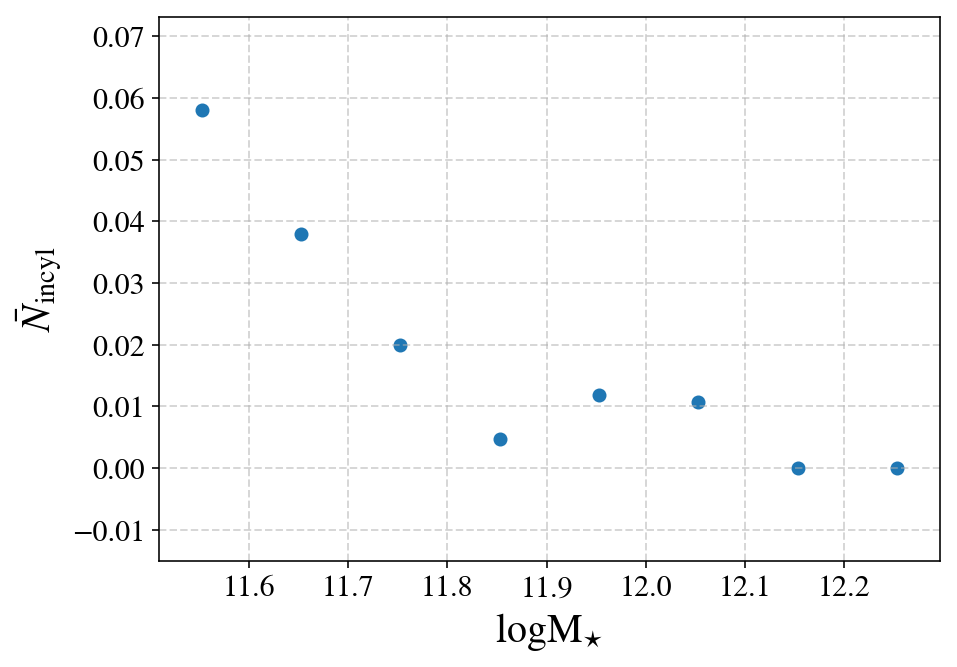

In [38]:
fig = plt.figure(figsize = [7,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_ylabel(r'$ \bar{N}_{\rm in cyl}$', fontsize = 20)
ax1.set_xlabel(r'$\log \rm M_{\star}$', fontsize = 20)
ax1.scatter(mass_center_true, means)

### Now try getting he PDR data curve. `halotools` doesn't like our coordinates (ra, dec, z), so I'll write my own (similar) function

In [39]:
def pdr_pairs(i, in_table, z_lim): 
    
    # the object we choose here is going to be a central by the way we have defined things
    cent_gal = in_table[i] 
    
    # this was a trick that song used to make a new catalog for the other objects of interest.
    # the utility is that we don't have to loop through the whole catalog EVERY TIME
    cat_use = copy.deepcopy(pdr_use[(pdr_use['logm_max'] > cent_gal['logm_max'])])
    
    
    # find the galaxies within the delta z limit
    dz= cat_use[np.abs(cent_gal['z_best'] - cat_use['z_best']) <= z_lim]
    
    pair_index = [] # list of indices of objects within cylinder
    
    if len(dz) > 0:
        # find separation for gals within dz
        dz['sep'] = SkyCoord(cent_gal['ra']*u.deg, cent_gal['dec']*u.deg).separation(SkyCoord(dz['ra']*u.deg, dz['dec']*u.deg)).degree 
    for i in range(len(dz)):
        if dz['sep'][i] <= cent_gal['r_vir']:
            pair_index.append(dz['index'][i])
            
    num_pairs = len(pair_index)
    
    return(num_pairs)

In [40]:
# useful quantities
pdr_use['index'] = np.zeros(len(pdr_use['logm_max']))
for i in range(len(pdr_use['index'])):
    pdr_use['index'][i] = i

# Now to find r_halo
r_halo = mass_so.M_to_R((10**pdr_use['logmh_vir'])*h , pdr_use['z_best'], 'vir')/h #kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(pdr_use['z_best'])
pdr_use['r_vir'] = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

In [73]:
# attempt to clean up the process
mass_binned_tables = [Table(names = pdr_use.colnames), Table(names = pdr_use.colnames), 
                      Table(names = pdr_use.colnames), Table(names = pdr_use.colnames),
                      Table(names = pdr_use.colnames), Table(names = pdr_use.colnames),
                      Table(names = pdr_use.colnames), Table(names = pdr_use.colnames)]

for i in range(len(pdr_use)):
    if pdr_use['logm_max'][i] > 11.5 and pdr_use['logm_max'][i] < 11.6:
        mass_binned_tables[0].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.6 and pdr_use['logm_max'][i] < 11.7:
        mass_binned_tables[1].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.7 and pdr_use['logm_max'][i] < 11.8:
        mass_binned_tables[2].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.8 and pdr_use['logm_max'][i] < 11.9:
        mass_binned_tables[3].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.9 and pdr_use['logm_max'][i] < 12.0:
        mass_binned_tables[4].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.0 and pdr_use['logm_max'][i] < 12.1:
        mass_binned_tables[5].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.1 and pdr_use['logm_max'][i] < 12.2:
        mass_binned_tables[6].add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.2:
        mass_binned_tables[7].add_row(pdr_use[i])

In [96]:
counts = ([[], [], [], [], [], [], [], []]) # empty array to populate with counts
# now actually do CiC
for i in range(len(mass_binned_tables)):
    for j in range(len(mass_binned_tables[i])):
        counts[i].append(pdr_pairs(j, mass_binned_tables[i], .008))

In [101]:
for i in range(len(counts)):
    print( np.max(counts[i]))

4
2
1
1
1
0
0
0


<Container object of 3 artists>

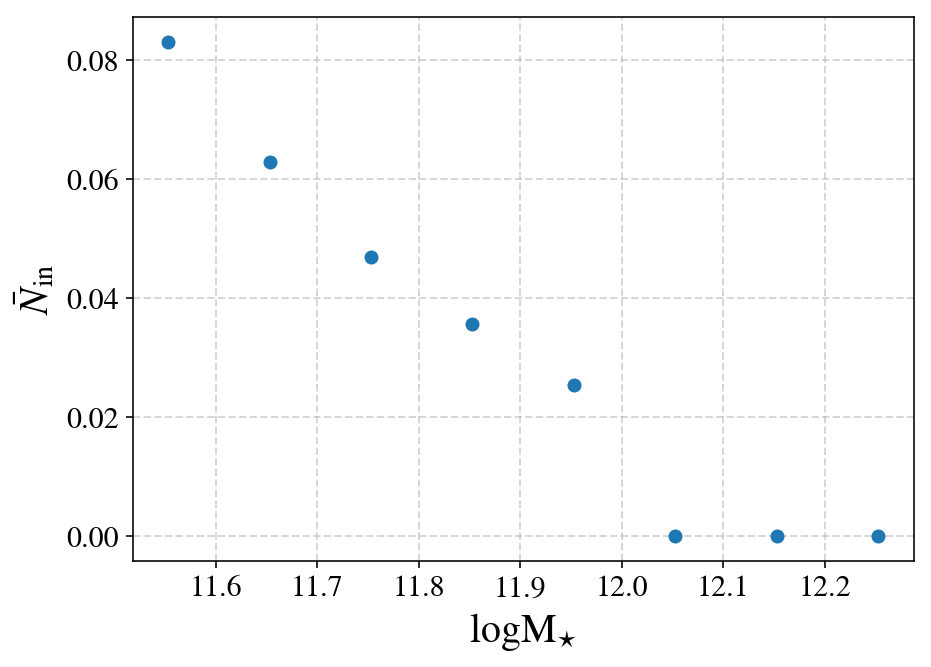

In [66]:
bin_11_5 = Table(names = pdr_use.colnames)
bin_11_6 = Table(names = pdr_use.colnames)
bin_11_7 = Table(names = pdr_use.colnames)
bin_11_8 = Table(names = pdr_use.colnames)
bin_11_9 = Table(names = pdr_use.colnames)
bin_12_0 = Table(names = pdr_use.colnames)
bin_12_1 = Table(names = pdr_use.colnames)
bin_12_2 = Table(names = pdr_use.colnames)


for i in range(len(pdr_use)):
    if pdr_use['logm_max'][i] > 11.5 and pdr_use['logm_max'][i] < 11.6:
        bin_11_5.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.6 and pdr_use['logm_max'][i] < 11.7:
        bin_11_6.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.7 and pdr_use['logm_max'][i] < 11.8:
        bin_11_7.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.8 and pdr_use['logm_max'][i] < 11.9:
        bin_11_8.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 11.9 and pdr_use['logm_max'][i] < 12.0:
        bin_11_9.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.0 and pdr_use['logm_max'][i] < 12.1:
        bin_12_0.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.1 and pdr_use['logm_max'][i] < 12.2:
        bin_12_1.add_row(pdr_use[i])
    if pdr_use['logm_max'][i] > 12.2:
        bin_12_2.add_row(pdr_use[i])
        
bin_11_5_counts = []
bin_11_6_counts = []
bin_11_7_counts = []
bin_11_8_counts = []
bin_11_9_counts = []
bin_12_0_counts = []
bin_12_1_counts = []
bin_12_2_counts = []


for i in range(len(bin_11_5)):
    bin_11_5_counts.append(pdr_pairs(i, bin_11_5, .008))
for i in range(len(bin_11_6)):
    bin_11_6_counts.append(pdr_pairs(i, bin_11_6, .008))
for i in range(len(bin_11_7)):
    bin_11_7_counts.append(pdr_pairs(i, bin_11_7, .008))
for i in range(len(bin_11_8)):
    bin_11_8_counts.append(pdr_pairs(i, bin_11_8, .008))
for i in range(len(bin_11_9)):
    bin_11_9_counts.append(pdr_pairs(i, bin_11_9, .008))
for i in range(len(bin_12_0)):
    bin_12_0_counts.append(pdr_pairs(i, bin_12_0, .008))
for i in range(len(bin_12_1)):
    bin_12_1_counts.append(pdr_pairs(i, bin_12_1, .008))
for i in range(len(bin_12_2)):
    bin_12_2_counts.append(pdr_pairs(i, bin_12_2, .008))
    
bins = [0,1,2,3,4,5,6,7]
hist_11_5, edges_11_5 = np.histogram(bin_11_5_counts,bins)
hist_11_6, edges_11_6 = np.histogram(bin_11_6_counts,bins)
hist_11_7, edges_11_7 = np.histogram(bin_11_7_counts,bins)
hist_11_8, edges_11_8 = np.histogram(bin_11_8_counts,bins)
hist_11_9, edges_11_9 = np.histogram(bin_11_9_counts,bins)
hist_12_0, edges_12_0 = np.histogram(bin_12_0_counts,bins)
hist_12_1, edges_12_1 = np.histogram(bin_12_1_counts,bins)
hist_12_2, edges_12_2 = np.histogram(bin_12_2_counts,bins)

mean_11_5 = (0*hist_11_5[0] + 1*hist_11_5[1] + 2*hist_11_5[2] + 3*hist_11_5[3])/sum(hist_11_5)
mean_11_6 = (0*hist_11_6[0] + 1*hist_11_6[1] + 2*hist_11_6[2])/sum(hist_11_6)
mean_11_7 = (0*hist_11_7[0] + 1*hist_11_7[1] + 2*hist_11_7[2])/sum(hist_11_7)
mean_11_8 = (0*hist_11_8[0] + 1*hist_11_8[1] + 2*hist_11_8[2])/sum(hist_11_8)
mean_11_9 = (0*hist_11_9[0] + 1*hist_11_9[1] + 2*hist_11_9[2])/sum(hist_11_9)
mean_12_0 = (0*hist_12_0[0] + 1*hist_12_0[1] + 2*hist_12_0[2])/sum(hist_12_0)
mean_12_1 = (0*hist_12_1[0] + 1*hist_12_1[1] + 2*hist_12_1[2])/sum(hist_12_1)
mean_12_2 = (0*hist_12_2[0] + 1*hist_12_2[1] + 2*hist_12_2[2])/sum(hist_12_2)

means = [mean_11_5, mean_11_6, mean_11_7, mean_11_8, mean_11_9, mean_12_0, mean_12_1, mean_12_2]

err = [np.sqrt(sum(hist_11_5))/sum(hist_11_5),
      np.sqrt(sum(hist_11_6))/sum(hist_11_6),
      np.sqrt(sum(hist_11_7))/sum(hist_11_7),
      np.sqrt(sum(hist_11_8))/sum(hist_11_8),0,0,0,0]
#      np.sqrt(sum(hist_11_9))/sum(hist_11_9),
#      np.sqrt(sum(hist_12_0))/sum(hist_12_0),
#      np.sqrt(sum(hist_12_1))/sum(hist_12_1),
#      np.sqrt(sum(hist_12_2))/sum(hist_12_2)]

fig = plt.figure(figsize = [7,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_ylabel(r'$ \bar{N}_{\rm in}$', fontsize = 20)
ax1.set_xlabel(r'$\log \rm M_{\star}$', fontsize = 20)
ax1.errorbar(mass_center_true, means, fmt = 'o')

## Now I want to work with randoms. The first thing I'm going to do is set up the table and check that the catalog Song sent is for the correct region.

In [52]:
# path to the data file
random_file = data_pth +'s16a_random_500k.npy'

# read in the array and make a table
randoms = Table(np.load(random_file))
randoms

ra,dec,field,jk,redshift,z
float64,float64,int64,int64,float64,float64
29.932068028235665,-3.990383163553301,5,0,0.0,0.823228405030071
132.71031544050894,1.1812907640265562,1,0,0.0,0.7173560438258898
140.12196091406872,3.240460489530151,1,0,0.0,0.257594664133045
136.49921258499833,-1.0299306731749192,1,0,0.0,0.7246959564215889
237.246892560633,42.47810251960571,4,0,0.0,0.356747536865089
221.91656450744262,0.6307976659972396,2,0,0.0,0.47977608822262463
216.01995830503026,-0.8049424725083352,2,0,0.0,0.6853082039340612
334.04642925504425,1.5125417691335883,6,0,0.0,0.2874827387193755
36.71679133447393,-2.729743420142457,5,0,0.0,0.339125399445356


It looks like the information we actually need here is in the `ra`, `dec`, and `z` columns. In fact, we actually want to replace every value  in the `z` column with a random redshift from our sample. I will write up some quick code to do so.

In [54]:
randoms.remove_columns(['field', 'jk', 'redshift'])
randoms

ra,dec,z
float64,float64,float64
29.932068028235665,-3.990383163553301,0.823228405030071
132.71031544050894,1.1812907640265562,0.7173560438258898
140.12196091406872,3.240460489530151,0.257594664133045
136.49921258499833,-1.0299306731749192,0.7246959564215889
237.246892560633,42.47810251960571,0.356747536865089
221.91656450744262,0.6307976659972396,0.47977608822262463
216.01995830503026,-0.8049424725083352,0.6853082039340612
334.04642925504425,1.5125417691335883,0.2874827387193755
36.71679133447393,-2.729743420142457,0.339125399445356


In [55]:
hsc_sample_z = pdr_use['z_best'] # all sample redshifts
random_redshift_index = np.random.randint(len(hsc_sample_z), size = len(randoms))
randoms['z'] = hsc_sample_z[random_redshift_index]

In [56]:
randoms

ra,dec,z
float64,float64,float64
29.932068028235665,-3.990383163553301,0.3325900137424469
132.71031544050894,1.1812907640265562,0.2877100110054016
140.12196091406872,3.240460489530151,0.31356000900268555
136.49921258499833,-1.0299306731749192,0.40647000074386597
237.246892560633,42.47810251960571,0.2991099953651428
221.91656450744262,0.6307976659972396,0.3239299952983856
216.01995830503026,-0.8049424725083352,0.2618499994277954
334.04642925504425,1.5125417691335883,0.31711000204086304
36.71679133447393,-2.729743420142457,0.3750179708003998


Looks like that worked! Now to check that the regions line up in `ra` and `dec`

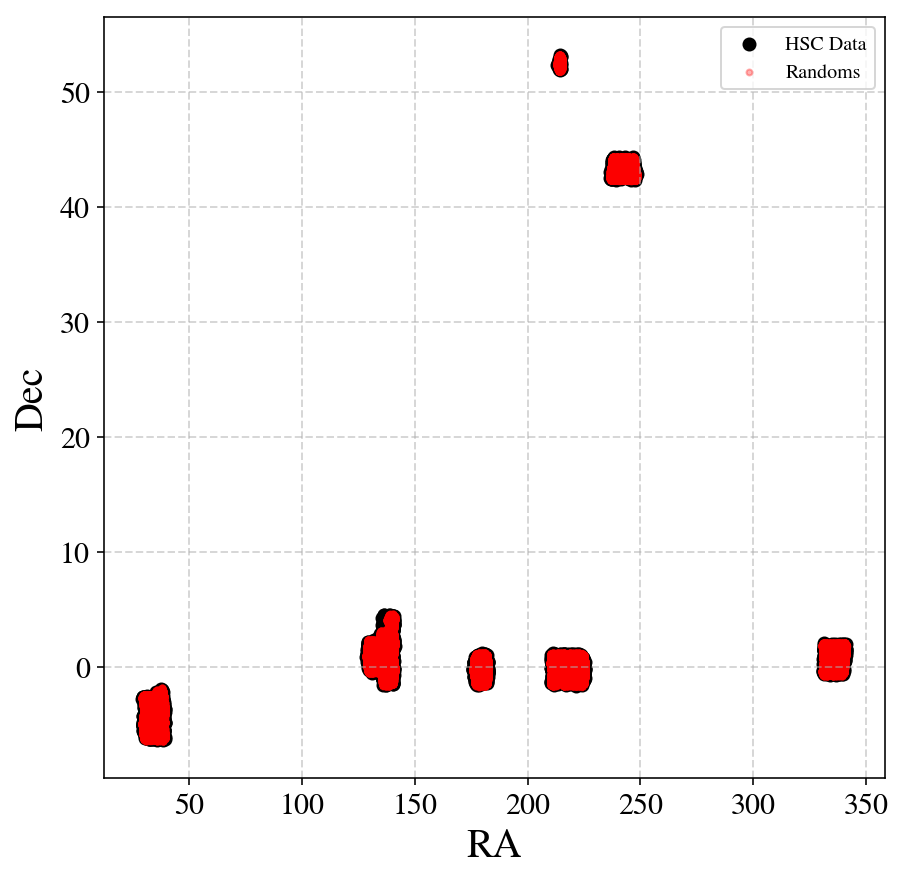

In [62]:
# plot setup
fig = plt.figure(figsize = [7,7])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.set_ylabel(r'Dec', fontsize = 20)
ax1.set_xlabel(r'RA', fontsize = 20)

ax1.scatter(pdr_use['ra'],pdr_use['dec'] , marker = 'o', color = 'k', label = 'HSC Data')
ax1.scatter(randoms['ra'],randoms['dec'] , marker = '.', color = 'r', alpha = .3, label = 'Randoms')
ax1.legend()

$\Rightarrow$ okay, cool, so that worked! Now I need to perfrom the CiC and cross-correlate with the sample and randoms